In [1]:
import pandas as pnd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sb

# import match data

In [2]:
match_01 = pnd.read_csv('01_klebsiella/tables/biolog_match.csv', index_col=0)
match_02 = pnd.read_csv('02_ralstonia/tables/biolog_match.csv', index_col=0)
match_03 = pnd.read_csv('03_pseudomonas/tables/biolog_match.csv', index_col=0)


fns_01 = pnd.read_csv('01_klebsiella/tables/biolog_fns.csv', index_col=0)
fns_02 = pnd.read_csv('02_ralstonia/tables/biolog_fns.csv', index_col=0)
fns_03 = pnd.read_csv('03_pseudomonas/tables/biolog_fns.csv', index_col=0)

# remove substrates never modeled

by any of the tools

In [3]:
match_01 = match_01[
    match_01['model_value_gempipe'].notna() | \
    match_01['model_value_gempipe_rf'].notna() | \
    match_01['model_value_carveme'].notna() | \
    match_01['model_value_bactabolize'].notna() | \
    match_01['model_value_gapseq'].notna()]

match_02 = match_02[
    match_02['model_value_gempipe'].notna() | \
    match_02['model_value_gempipe_rf'].notna() | \
    match_02['model_value_carveme'].notna() | \
    match_02['model_value_bactabolize'].notna() | \
    match_02['model_value_gapseq'].notna()]

match_03 = match_03[
    match_03['model_value_gempipe'].notna() | \
    match_03['model_value_gempipe_rf'].notna() | \
    match_03['model_value_carveme'].notna() | \
    match_03['model_value_bactabolize'].notna() | \
    match_03['model_value_gapseq'].notna()]

# define reduced substrate set

Exclude substrates that clearly need addition of reactions in the pan-model.

In [4]:
# 01_klebsiella
print('n_sustrates:', len(match_01['substrate'].unique()))
to_exclude = match_01['substrate'].isin(fns_01[(fns_01['pan_growth']<0.001) | (fns_01['pan_growth'].isna())].index)
match_01_red = match_01[~to_exclude]
print('reduced:', len(match_01_red['substrate'].unique()))


n_sustrates: 90
reduced: 78


In [5]:
# 02_ralstonia
print('n_sustrates:', len(match_02['substrate'].unique()))
to_exclude = match_02['substrate'].isin(fns_02[(fns_02['pan_growth']<0.001) | (fns_02['pan_growth'].isna())].index)
match_02_red = match_02[~to_exclude]
print('reduced:', len(match_02_red['substrate'].unique()))


n_sustrates: 147
reduced: 134


In [6]:
# 03_pseudomonas
print('n_sustrates:', len(match_03['substrate'].unique()))
to_exclude = match_03['substrate'].isin(fns_03[(fns_03['pan_growth']<0.001) | (fns_03['pan_growth'].isna())].index)
match_03_red = match_03[~to_exclude]
print('reduced:', len(match_03_red['substrate'].unique()))


n_sustrates: 93
reduced: 64


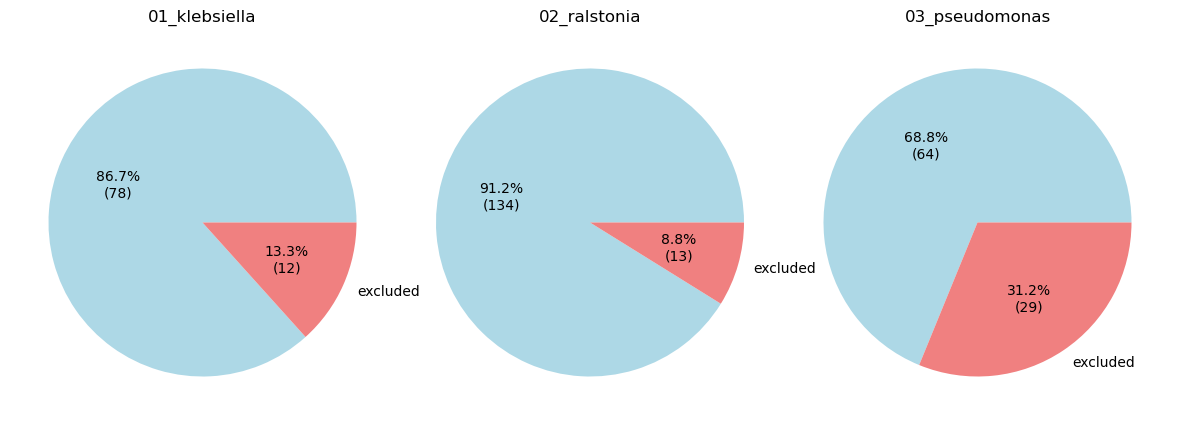

In [7]:
# make pie plots to show the proportion of excluded substrates:

fig, axs = plt.subplots(
    nrows=1, ncols=3,
    figsize=(15, 5), 
    gridspec_kw={'width_ratios': [1, 1, 1]}
) 
plt.subplots_adjust(wspace=0.0, hspace=0.0)


def autopct_format(pct, all_values):
    absolute = int(round(pct * sum(all_values) / 100))  
    return f"{pct:.1f}%\n({absolute})" 


for i, (dataset, match, match_red) in enumerate(zip(
    ['01_klebsiella', '02_ralstonia', '03_pseudomonas'],
    [match_01, match_02, match_03],
    [match_01_red, match_02_red, match_03_red]
)):
    
    len_excluded = len(match['substrate'].unique()) - len(match_red['substrate'].unique())
    len_red = len(match['substrate'].unique()) - len_excluded
    
    sizes = [len_red, len_excluded]  # slices dim
    labels = ['', 'excluded']  # labels 
    colors = ["lightblue", "lightcoral"]  
    explode = (0, 0)  # emphasizing slices (optional)
    
    axs[i].pie(
        sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), 
        colors=colors, explode=explode, startangle=0)
    axs[i].set_title(dataset)  # Add a title
    
    

# define main functions

In [8]:
def create_biolog_stacked_df(
    matches, datasets, tools = ['gempipe', 'gempipe_rf', 'carveme', 'gapseq', 'bactabolize']):


    # into a dict, collect metrics per tool per strain:
    strain_2_metrics = {}
    for match, dataset in zip(matches, datasets): 
        if dataset not in strain_2_metrics.keys(): 
            strain_2_metrics[dataset] = {}

        for r in match.index:
            strain = match.loc[r, 'strain']
            if strain not in strain_2_metrics[dataset].keys(): 
                strain_2_metrics[dataset][strain] = {tool: {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'infeasible': 0} for tool in tools}

            for c in match.columns: 
                if   c=='call_gempipe': 
                    tool = 'gempipe'
                elif   c=='call_gempipe_rf': 
                    tool = 'gempipe_rf'
                elif c=='call_carveme': 
                    tool = 'carveme'
                elif c=='call_gapseq': 
                    tool = 'gapseq'
                elif c=='call_bactabolize': 
                    tool = 'bactabolize'
                else: 
                    continue

                call = match.loc[r, c]
                try: strain_2_metrics[dataset][strain][tool][call] += 1
                except: continue  # Nan in wet-lab data

                
    # convert dict into dataframe:
    def get_dataframe(strain_2_metrics):

        df_results = []
        for dataset,v1 in strain_2_metrics.items():
            for strain,v2 in v1.items():
                for tool,v3 in v2.items():
                    row_dict = {'dataset': dataset, 'strain': strain, 'tool': tool}
                    for metric,v4 in v3.items():
                        row_dict[metric] = v4
                    df_results.append(row_dict)
        df_results = pnd.DataFrame.from_records(df_results)
        return df_results
    df_results = get_dataframe(strain_2_metrics)
    
    
    # format the dataframe for a stacked barplot: 
    for dataset,v1 in strain_2_metrics.items():
        for strain,v2 in v1.items():
            for tool,v3 in v2.items():
                TP = strain_2_metrics[dataset][strain][tool]['TP']
                TN = strain_2_metrics[dataset][strain][tool]['TN']
                FP = strain_2_metrics[dataset][strain][tool]['FP']
                FN = strain_2_metrics[dataset][strain][tool]['FN']
                infeasible = strain_2_metrics[dataset][strain][tool]['infeasible']

                TP, TN, FP, FN, infeasible = TP, TP+TN, TP+TN+FP, TP+TN+FP+FN, TP+TN+FP+FN+infeasible

                strain_2_metrics[dataset][strain][tool]['TP'] = TP  / infeasible * 100
                strain_2_metrics[dataset][strain][tool]['TN'] = TN  / infeasible * 100
                strain_2_metrics[dataset][strain][tool]['FP'] = FP  / infeasible * 100
                strain_2_metrics[dataset][strain][tool]['FN'] = FN  / infeasible * 100
                strain_2_metrics[dataset][strain][tool]['infeasible'] = infeasible  / infeasible * 100
    df_results_stacked = get_dataframe(strain_2_metrics)
    
    
    return df_results, df_results_stacked



In [9]:

def plot_biolog_stacked_df(df_results_stacked, title='full_set'):

    sb.set_theme(style="whitegrid")

    g = sb.FacetGrid(df_results_stacked, col="dataset",  height=4, aspect=0.55)
    g = g.map_dataframe(sb.barplot, x='tool', y='infeasible', color='grey', errorbar='sd', err_kws={'color': 'black'}, )
    g = g.map_dataframe(sb.barplot, x='tool', y='FN', color='blueviolet', errorbar='sd', err_kws={'color': 'black'}, )
    g = g.map_dataframe(sb.barplot, x='tool', y='FP', color='violet', errorbar='sd', err_kws={'color': 'black'}, )
    g = g.map_dataframe(sb.barplot, x='tool', y='TN', color='forestgreen', errorbar='sd', err_kws={'color': 'black'}, )
    g = g.map_dataframe(sb.barplot, x='tool', y='TP', color='yellowgreen', errorbar='sd', err_kws={'color': 'black'}, )

    infeasible_patch = Patch(color='grey', label='infeasible')
    FN_patch = Patch(color='blueviolet', label='FN')
    FP_patch = Patch(color='violet', label='FP')
    TN_patch = Patch(color='forestgreen', label='TN')
    TP_patch = Patch(color='yellowgreen', label='TP')

    # add the custom legend to the plot
    legend = plt.legend(
        handles=[infeasible_patch, FN_patch, FP_patch, TN_patch, TP_patch],
        bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False, title='     metric')


    g.set_xticklabels(rotation=30, ha='right')

    g.set_axis_labels('', '% of substrates')


    axes = g.axes.flatten()
    axes[0].set_title("01_klebsiella")
    axes[1].set_title("02_ralstonia")
    axes[2].set_title("03_pseudomonas")

    g.fig.suptitle(title, y=1.05)
    return g

In [10]:
def create_biolog_metrics_df(df_results):

    df_metrics = []
    for index, row in df_results.iterrows():

        TP = row['TP']
        TN = row['TN']
        FP = row['FP']
        FN = row['FN']
        infeasible = row['infeasible']
        
        
        #if TP==0: TP=1
                

        factor = (TP + FP + TN + FN ) / (TP + FP + TN + FN + infeasible)     
        try: precision = TP / (TP + FP ) * factor *100                          
        except: precision = 0                                             # handle divisions by 0
        try: recall = TP / (TP + FN ) * factor *100                       # ('sensitivity' is synonym)
        except: recall = 0                                                # handle divisions by 0
        try: specificity = TN / (TN + FP ) * factor *100                                
        except: specificity = 0                                           # handle divisions by 0
        try: accuracy = (TP + TN) / (TP + FP + TN + FN ) * factor *100                 
        except: accuracy = 0                                              # handle divisions by 0


        for metric, value in zip(['precision', 'recall', 'specificity', 'accuracy'], [precision, recall, specificity, accuracy]):
            df_metrics.append({'dataset': row['dataset'], 'strain': row['strain'], 'tool': row['tool'], 'metric': metric, 'value': value})

    df_metrics = pnd.DataFrame.from_records(df_metrics)
    return df_metrics

In [11]:
def plot_biolog_metrics_df(df_metrics, title='full_set'):
    
    sb.set_theme(style="whitegrid")
    

    palette1 = {'reference': 'darkgrey', 'gempipe': 'C0', 'gempipe_rf': 'C4', 'carveme': 'C1', 'gapseq': 'C2', 'bactabolize': 'C3'}
    g = sb.FacetGrid(df_metrics, col="dataset", height=4)
    g = g.map_dataframe(sb.barplot, x='metric', y='value', hue='tool', palette=palette1, edgecolor='white', errorbar='sd', err_kws={'color': 'black'})
    g = g.add_legend(title='tools')


    g.set_axis_labels('', '% performance')
    #g.set_xticklabels(rotation=30, ha='right')


    axes = g.axes.flatten()
    axes[0].set_title("01_klebsiella")
    axes[1].set_title("02_ralstonia")
    axes[2].set_title("03_pseudomonas")

    g.fig.suptitle(title, y=1.05)
    return g

# plot full_set

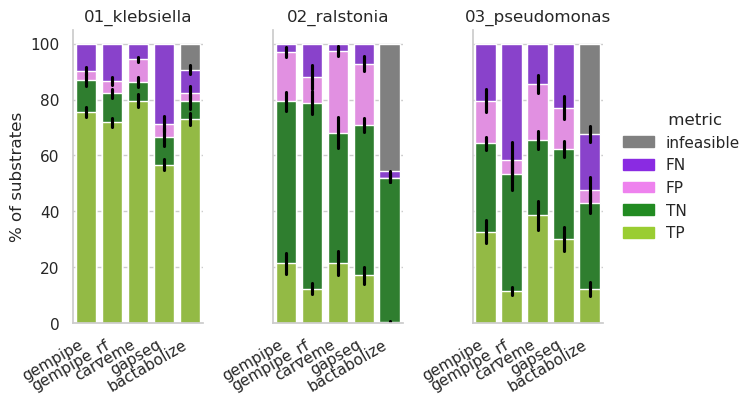

In [12]:
df_results_full, df_results_stacked_full = create_biolog_stacked_df(
    [match_01, match_02, match_03], ['01_klebsiella', '02_ralstonia', '03_pseudomonas'])
plot_biolog_stacked_df(df_results_stacked_full, title='')

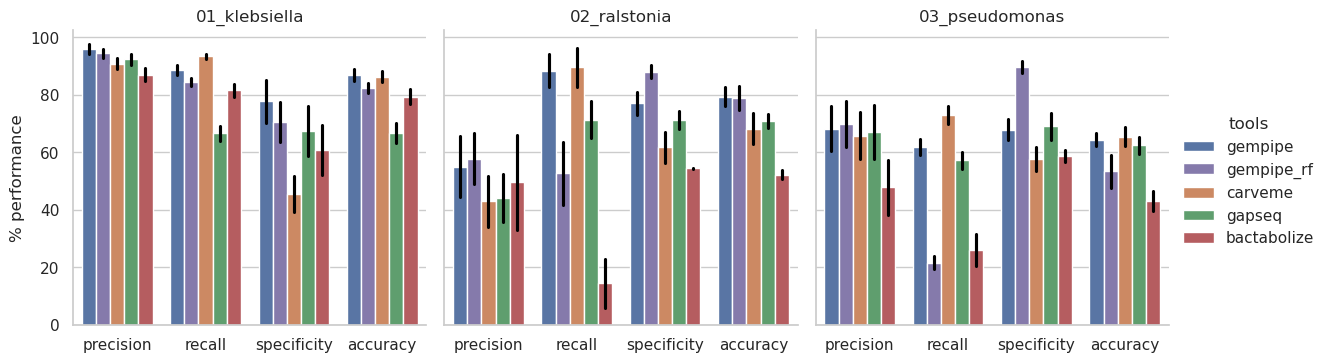

In [13]:
df_metrics_full = create_biolog_metrics_df(df_results_full)
plot_biolog_metrics_df(df_metrics_full, title='')

# plot reduced_set


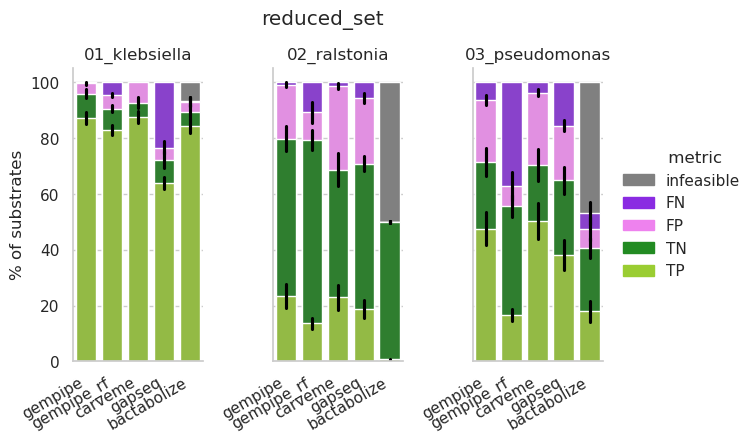

In [14]:
df_results_red, df_results_stacked_red = create_biolog_stacked_df(
    [match_01_red, match_02_red, match_03_red], ['01_klebsiella', '02_ralstonia', '03_pseudomonas'])
plot_biolog_stacked_df(df_results_stacked_red, title='reduced_set')

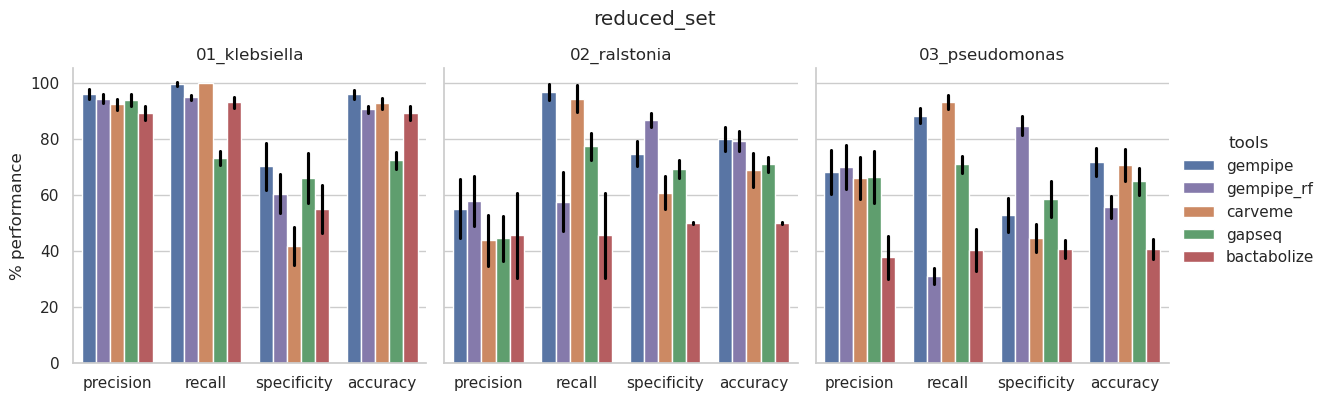

In [15]:
df_metrics_red = create_biolog_metrics_df(df_results_red)
plot_biolog_metrics_df(df_metrics_red, title='reduced_set')